In [5]:
import pandas as pd 
import numpy as np
import public_timeseries_testing_util as optiver2023
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, unpack_sequence, unpad_sequence
import torch
from tqdm import trange,tqdm
import torch.nn as nn 
import torch.optim as optim
import wandb
import torch_classes
import matplotlib as mpl

In [7]:
val_data = pd.read_feather('validation_outputs/true-elevator-437_validation_output_370.fth')

In [8]:
val_data

,stock,day,time,target,ask_target,ask_pred,bid_target,bid_pred,wap_target,wap_pred,actual_wap
0,0,384,0,-2.340078,-1.91,2.913811,-0.95,0.814842,-0.14,0.814842,1.000000
1,1,384,0,-8.130074,3.45,-1.336881,1.15,-3.397530,5.65,-3.397530,1.000000
2,2,384,0,0.790358,-6.54,-3.508748,-8.55,-6.034808,-3.27,-6.034808,1.000000
3,3,384,0,6.059408,-7.96,1.155803,-9.94,-0.911065,-8.54,-0.911065,1.000000
4,4,384,0,0.499487,-2.22,4.390183,-3.89,2.731035,-2.98,2.731035,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
921097,153,477,48,5.799532,0.00,-5.277267,0.00,-6.358480,-2.88,-6.358480,0.998570
921098,199,477,48,2.510548,0.00,2.781678,0.00,2.732481,0.41,2.732481,1.003296
921099,79,477,48,4.520416,0.00,0.095887,0.00,-0.553564,-1.60,-0.553564,0.998050
921100,135,477,48,3.370047,0.00,0.668441,0.00,0.068669,-0.46,0.068669,0.999369


In [9]:
# val_data.to_excel('validation_outputs/true-elevator-437_validation_output_370.xlsx')

In [10]:
val_data

,stock,day,time,target,ask_target,ask_pred,bid_target,bid_pred,wap_target,wap_pred,actual_wap
0,0,384,0,-2.340078,-1.91,2.913811,-0.95,0.814842,-0.14,0.814842,1.000000
1,1,384,0,-8.130074,3.45,-1.336881,1.15,-3.397530,5.65,-3.397530,1.000000
2,2,384,0,0.790358,-6.54,-3.508748,-8.55,-6.034808,-3.27,-6.034808,1.000000
3,3,384,0,6.059408,-7.96,1.155803,-9.94,-0.911065,-8.54,-0.911065,1.000000
4,4,384,0,0.499487,-2.22,4.390183,-3.89,2.731035,-2.98,2.731035,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
921097,153,477,48,5.799532,0.00,-5.277267,0.00,-6.358480,-2.88,-6.358480,0.998570
921098,199,477,48,2.510548,0.00,2.781678,0.00,2.732481,0.41,2.732481,1.003296
921099,79,477,48,4.520416,0.00,0.095887,0.00,-0.553564,-1.60,-0.553564,0.998050
921100,135,477,48,3.370047,0.00,0.668441,0.00,0.068669,-0.46,0.068669,0.999369


In [11]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]

In [12]:
weights_df = pd.DataFrame(data=list(zip(range(0,201),weights)),columns=['stock','index_weight'])

In [13]:
val_data = val_data.merge(weights_df,on='stock')

In [14]:
def generate_prev_race(df_in, df_g, rolling_window=10, factor=''):
    df = df_in.copy()
    original_cols = df_in.columns
    df[f'initial_wap'] = df_g['actual_wap'].transform('first')
    return(df)

def generate_index(df_in, df_g, rolling_window=10, factor=''):
    df = df_in.copy()
    df[f'index_wap'] = df_g['wap_weighted'].transform('mean')
    df[f'index_wap_t60_pred'] = df_g['wap_weighted_t60_pred'].transform('mean')
    return(df)

def generate_index_2(df_in, df_g, rolling_window=10, factor=''):
    df = df_in.copy()
    # df[f'index_wap_t-60'] = df_g['index_wap'].shift(6)
    df[f'index_wap_init'] = df_g['index_wap'].transform('first')
    return(df)

# def generate_index_3(df_in, df_g, rolling_window=10, factor=''):
#     df = df_in.copy()
#     df[f'index_wap_t-60'] = df_g['index_wap_move_to_init'].shift(6)
#     return(df)

In [15]:
val_data['wap_t60_pred'] = val_data['actual_wap']+val_data['wap_pred']/10000
val_data['wap_weighted'] = val_data['actual_wap']*val_data['index_weight']
val_data['wap_weighted_t60_pred'] = val_data['wap_t60_pred']*val_data['index_weight']


In [16]:
# val_data['index_wap'] = val_data.wap_weighted.mean()
# val_data['index_wap_t60_pred'] = val_data.wap_weighted_t60_pred.mean()

In [17]:
val_data.head(10)

,stock,day,time,target,ask_target,ask_pred,bid_target,bid_pred,wap_target,wap_pred,actual_wap,index_weight,wap_t60_pred,wap_weighted,wap_weighted_t60_pred
0,0,384,0,-2.340078,-1.91,2.913811,-0.95,0.814842,-0.14,0.814842,1.000000,0.004,1.000081,0.004000,0.004000
1,0,384,1,2.410412,-1.91,2.851236,-2.86,0.138508,-3.81,0.138508,0.999630,0.004,0.999644,0.003999,0.003999
2,0,384,2,-3.060102,3.82,4.429021,3.82,2.086997,4.06,2.086997,1.000086,0.004,1.000295,0.004000,0.004001
3,0,384,3,-1.540184,4.77,4.450240,5.73,2.865995,5.13,2.865995,1.000058,0.004,1.000345,0.004000,0.004001
4,0,384,4,-4.709959,8.60,6.066348,7.64,5.189548,10.05,5.189548,1.000378,0.004,1.000897,0.004002,0.004004
5,0,384,5,-3.399849,8.60,7.978274,9.56,7.472745,10.14,7.472745,1.000578,0.004,1.001325,0.004002,0.004005
6,0,384,6,2.280474,3.82,7.806184,2.86,7.616690,3.70,7.616690,1.000014,0.004,1.000776,0.004000,0.004003
7,0,384,7,4.129410,4.77,7.436947,4.77,7.429728,5.79,7.429728,1.000011,0.004,1.000754,0.004000,0.004003
8,0,384,8,5.480051,4.77,6.732557,3.82,6.889439,3.32,6.889439,0.999680,0.004,1.000369,0.003999,0.004001
9,0,384,9,3.830194,3.82,5.761528,2.86,6.036323,2.64,6.036323,0.999545,0.004,1.000149,0.003998,0.004001


In [18]:
val_data['wap_weighted'] = val_data['actual_wap']*val_data['index_weight']
val_data_g = val_data.groupby(['stock','day'])
val_data = generate_prev_race(val_data,val_data_g)
val_data['delta_wap'] = val_data['actual_wap']/val_data['wap_t60_pred']

val_data_g = val_data.groupby(['time','day'])
val_data = generate_index(val_data,val_data_g)


val_data['wap_move_to_init'] = val_data['actual_wap']/val_data['initial_wap']
val_data_g = val_data.groupby(['day'])
val_data = generate_index_2(val_data,val_data_g)

val_data['index_wap_move_to_init'] = val_data['index_wap']/val_data['index_wap_init']
val_data['index_wap_t60_pred2'] = val_data['index_wap_t60_pred']/val_data['index_wap_init']
# val_data_g = val_data.groupby(['day'])
# val_data = generate_index_3(val_data,val_data_g)

In [19]:
val_data['target_calc'] = -((val_data['wap_t60_pred']/val_data['actual_wap'])-(val_data['index_wap_t60_pred2']/val_data['index_wap_move_to_init']))*10000

In [20]:
val_data

,stock,day,time,target,ask_target,ask_pred,bid_target,bid_pred,wap_target,wap_pred,...,wap_weighted_t60_pred,initial_wap,delta_wap,index_wap,index_wap_t60_pred,wap_move_to_init,index_wap_init,index_wap_move_to_init,index_wap_t60_pred2,target_calc
0,0,384,0,-2.340078,-1.91,2.913811,-0.95,0.814842,-0.14,0.814842,...,0.004000,1.0,0.999919,0.005000,0.005000,1.000000,0.005,1.000000,1.000010,-0.710346
1,0,384,1,2.410412,-1.91,2.851236,-2.86,0.138508,-3.81,0.138508,...,0.003999,1.0,0.999986,0.005000,0.005000,0.999630,0.005,1.000100,1.000062,-0.516367
2,0,384,2,-3.060102,3.82,4.429021,3.82,2.086997,4.06,2.086997,...,0.004001,1.0,0.999791,0.005000,0.005000,1.000086,0.005,0.999983,0.999982,-2.099390
3,0,384,3,-1.540184,4.77,4.450240,5.73,2.865995,5.13,2.865995,...,0.004001,1.0,0.999713,0.005001,0.005001,1.000058,0.005,1.000120,1.000186,-2.203843
4,0,384,4,-4.709959,8.60,6.066348,7.64,5.189548,10.05,5.189548,...,0.004004,1.0,0.999482,0.005001,0.005002,1.000378,0.005,1.000267,1.000451,-3.347914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921097,102,477,44,2.830029,-3.57,1.420855,-2.38,0.423715,1.03,0.423715,...,0.005992,1.0,0.999958,0.005001,0.005001,0.998659,0.005,1.000182,1.000180,-0.440254
921098,102,477,45,3.449917,1.19,1.015683,-0.59,0.088037,-1.23,0.088037,...,0.005990,1.0,0.999991,0.005000,0.005000,0.998268,0.005,0.999981,0.999983,-0.064227
921099,102,477,46,3.110170,-2.98,0.183996,-3.57,-0.779746,-0.59,-0.779746,...,0.005989,1.0,1.000078,0.005000,0.005000,0.998192,0.005,0.999914,0.999908,0.718989
921100,102,477,47,5.489588,-1.79,0.088921,-2.38,-0.774579,-2.57,-0.774579,...,0.005990,1.0,1.000078,0.005000,0.005000,0.998330,0.005,0.999964,0.999957,0.708302


In [21]:
loss = abs(val_data['target']-val_data['target_calc'])

In [22]:
loss.mean()

4.532781182027615

In [ ]:
def generate_index(df_in, df_g, rolling_window=10, factor=''):
    df = df_in.copy()
    df[f'index_wap'] = df_g['wap_weighted'].transform('mean')
    return(df)

In [2]:
env = optiver2023.make_env()
iter_test = env.iter_test()

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [2]:
train = pd.read_csv('train.csv')
train.head()
train.date_id.value_counts()

date_id
480    11000
353    11000
363    11000
362    11000
360    11000
       ...  
4      10560
2      10505
1      10505
3      10505
0      10505
Name: count, Length: 481, dtype: int64

In [8]:
x = train.groupby('date_id')[['target']].std().reset_index()
x

,date_id,target
0,0,8.168276
1,1,9.041150
2,2,9.153744
3,3,8.285481
4,4,8.244715
...,...,...
476,476,7.446479
477,477,7.664500
478,478,7.532644
479,479,8.829320


<Axes: xlabel='date_id', ylabel='target'>

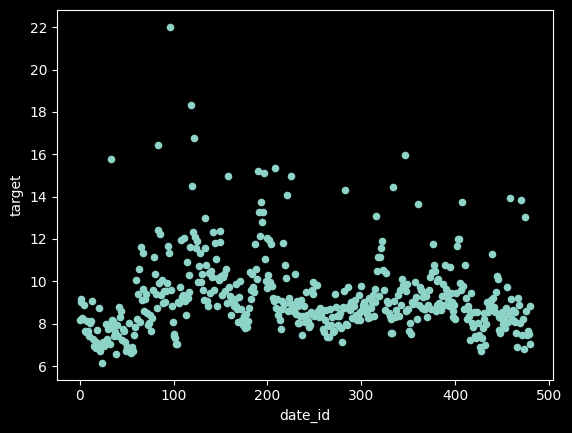

In [9]:
x.plot.scatter('date_id','target')

In [5]:
targets = train.target.value_counts(sort=True)
targets

target
-0.159740      3477
-0.759959      3471
-0.050068      3470
-0.079870      3467
 1.109838      3459
               ... 
 62.299965        1
 59.139730        1
-70.880060        1
-108.349920       1
-72.960260        1
Name: count, Length: 15934, dtype: int64